# SMA策略
使用简单移动平均线对中兴通讯进行策略回测

In [1]:
import data_request
import pandas as pd

取出中兴国际000063.SZ从2021年到2023年的数据

In [2]:
df = data_request.stock_time_sequence('000063.SZ', ['open', 'close', 'low', 'high', 'volume'], '2019-01-01','2023-4-7')

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2021 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


数据格式如下

In [3]:
print(df.tail())
df.index = pd.DatetimeIndex(df.index)
df.index[-5:]

             OPEN  CLOSE    LOW   HIGH       VOLUME
2023-03-31  32.12  32.56  31.55  32.83  101158844.0
2023-04-03  32.47  32.28  29.93  32.73  258719346.0
2023-04-04  31.53  32.52  31.40  33.15  148665433.0
2023-04-06  32.00  33.64  31.70  34.68  144408305.0
2023-04-07  35.43  37.00  35.41  37.00  277566040.0


DatetimeIndex(['2023-03-31', '2023-04-03', '2023-04-04', '2023-04-06',
               '2023-04-07'],
              dtype='datetime64[ns]', freq=None)

以下是最简单的均线策略：

取$SMA_N(t) = \frac{1}{N}\sum_{n=0}^N p_{t-n}$，若$SMA_N(t) > SMA_N(t-1)$则买入，反之则卖出。

风控信号：不止损不止盈

我们先计算每日的均线值

In [4]:
df['ma5'] = df.CLOSE.rolling(5).mean()
df['ma10'] = df.CLOSE.rolling(10).mean()
df['ma20'] = df.CLOSE.rolling(20).mean()
df.tail()

,OPEN,CLOSE,LOW,HIGH,VOLUME,ma5,ma10,ma20
2023-03-31,32.12,32.56,31.55,32.83,101158844.0,33.588,34.325,33.5645
2023-04-03,32.47,32.28,29.93,32.73,258719346.0,33.186,34.183,33.5405
2023-04-04,31.53,32.52,31.40,33.15,148665433.0,32.730,34.045,33.6090
2023-04-06,32.00,33.64,31.70,34.68,144408305.0,32.520,33.837,33.7210
2023-04-07,35.43,37.00,35.41,37.00,277566040.0,33.600,33.877,33.9415


数据准备完成！现在编制回测系统

## 回测系统
编制回测系统主要分为两步：1. 仓位管理系统； 2. 循环执行策略。一步步理清逻辑后，写起来很简单。

In [60]:
import datetime
import math

class backtest():
    def __init__(self, param):
        self.qvcode = '000063.SZ' # 标的
        self.holdings = {} # 仓位字典，key是标的名字，key对应的element也是一个字典，keys是成本价与持仓数量
        self.initial_cash = 10000000 # 初始资金
        self.cash = 10000000 # 初始化现金
        self.param = param # 参数读取
    
    def feedData(self, df):
        self.df = df # 传入数据，要求index为datetime.datetime格式
        self.trade_cal = self.df.index # 获取交易日历

    def feedStrategy(self, strategy):
        self.strategy = strategy(self, period = self.param) # 传入策略，策略稍后定义

    def run(self, begin, end):
        """
        @param
        ------
        begin: datetime.date() or datetime.datetime()
        """
        self.portfolio_net_value = pd.Series(None, dtype = float)
        self.benchmark_net_value = pd.Series(None, dtype = float)
        self.begin = begin
        for date in self.trade_cal:
            if begin <= date <= end:
                self.strategy.next(date, df.loc[date])

    def portfolio_value(self, date):
        """
        返回指定日期收盘后的资产总值

        @param
        ------
            date: datetime.date() or datetime.datetime()
        """
        if self.holdings == {}:
            return self.cash
        else:
            stock_value = 0
            for stock in self.holdings.keys():
                stock_value += self.df.CLOSE[date] * self.holdings[stock]['amount']
            return stock_value + self.cash

    def order(self, qvcode, price, amount):
        """
        下单函数，非常关键

        @param
        ------
            qvcode: str
                要下单的股票代码
            price: float
                下单价格
            amount: int
                下单数量，股数，需要自行确保下单数为100的整数倍
        """
        self.cash -= price * amount # 先把现金扣掉
        # 这个股票没有持仓的情况
        if qvcode not in self.holdings.keys():
            self.holdings[qvcode] = {'price': price, 'amount': amount} # 直接下单就行
        # 有持仓的情况
        else:
            current_holdings = self.holdings[qvcode] # 获取这个股票的持仓数量与成本
            if current_holdings['amount'] + amount != 0: # 没有平仓的情况
                # 重新计算成本与数量并更新字典
                price = (current_holdings['price'] * current_holdings['amount'] + amount * price) / (current_holdings['amount'] + amount)
                amount = current_holdings['amount'] + amount
                self.holdings[qvcode] = {'price': price, 'amount': amount}
            else: # 平仓的情况
                self.holdings.pop(qvcode) # 把股票从字典里删除

有了回测系统就可以写策略了

In [61]:
class MyStrategy():
    def __init__(self, backtest, period):
        self.broker = backtest
        self.df_cyc_bars = backtest.df
        self.period = period # 指定的均线周期

    def next(self, date, bar):
        # 计算在指定周期下的均线值与昨日均线值
        bar['ma'] = self.df_cyc_bars.CLOSE.rolling(self.period).mean()[date]
        bar['ma_last_day'] = self.df_cyc_bars.shift(1).CLOSE.rolling(self.period).mean()[date]
        if self.broker.holdings == {}: # 如果没有开仓
            if bar.ma > 1.01 * bar.ma_last_day: # 今日均线大于昨日均线
                amount = math.floor(self.broker.cash / bar.CLOSE / 100) * 100
                self.broker.order(self.broker.qvcode, bar.CLOSE, amount)
        elif bar.ma < 0.99 * bar.ma_last_day: # 已经开仓且今日均线小于昨日均线
            amount = self.broker.holdings[self.broker.qvcode]['amount']
            self.broker.order(self.broker.qvcode, bar.CLOSE, -amount)
        # 记录基准净值与策略净值
        self.broker.benchmark_net_value = pd.concat([self.broker.benchmark_net_value, pd.Series(self.df_cyc_bars.CLOSE[date] / self.df_cyc_bars.CLOSE[self.broker.begin], index = [date])])
        self.broker.portfolio_net_value = pd.concat([self.broker.portfolio_net_value, pd.Series(self.broker.portfolio_value(date) / self.broker.initial_cash, index = [date])])

简单尝试一下这个策略

In [62]:
test = backtest(param = 5)
test.feedData(df)
begin = datetime.datetime(2019, 2, 1)
end = datetime.datetime(2023, 4, 7)
test.feedStrategy(MyStrategy)
test.run(begin, end)

跑起来没毛病，那就试着把它画出来看看

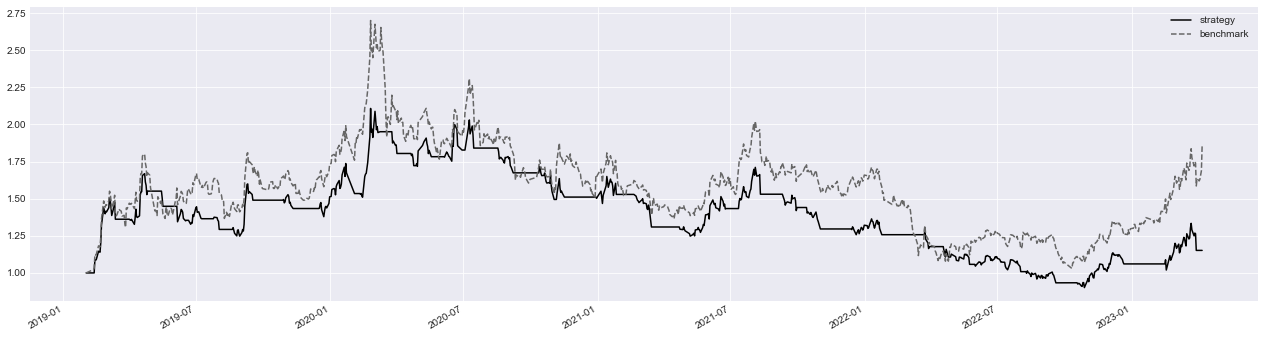

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
ser = test.portfolio_net_value
benchmark_nv = test.benchmark_net_value
plt.figure(figsize=(22,6))
plt.style.use('seaborn-dark')
result = ser.plot(label = 'strategy', legend = True)
benchmark = benchmark_nv.plot(style = '--', label = 'benchmark', legend = True)
plt.grid(True)
plt.show()

结果不太行，有可能是参数的问题，所以做个参数寻优

## 参数寻优
- 定义一个参数寻优函数，找出一段时间内的最有参数
- 找到一个更好的可视化方案

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

def optimizer(params, plot = False):
    if plot == True:
        plt.figure(figsize=(22,6))
        plt.style.use('seaborn-dark')
    begin = datetime.datetime(2019, 2, 1)
    end = datetime.datetime(2023, 4, 7)
    dict = {}
    for param in params:
        strategy = backtest(param)
        strategy.feedData(df)
        strategy.feedStrategy(MyStrategy)
        strategy.run(begin, end)
        if plot == True:
            strategy.portfolio_net_value.plot(label = f'N = {param}', legend = True)
        dict[param] = strategy.portfolio_net_value[-1]
        print(f'For parameter N = {param}, the total return is {(dict[param] - 1) * 100}%! ')
    if plot == True:
        benchmark_nv.plot(style = '--', label = 'benchmark', legend = True)
        plt.grid(True)
        plt.show()

使用优化器对5到60日的均线进行自动寻优

In [58]:
optimizer(range(5,60))

For parameter N = 5, the total return is 15.176518558604556%! 
For parameter N = 6, the total return is 60.08116716172343%! 
For parameter N = 7, the total return is 56.66405821079803%! 
For parameter N = 8, the total return is 40.269966365734476%! 
For parameter N = 9, the total return is 49.12733588081477%! 
For parameter N = 10, the total return is 70.6530687044744%! 
For parameter N = 11, the total return is 52.14716009214624%! 
For parameter N = 12, the total return is 14.48941501431744%! 
For parameter N = 13, the total return is 12.449206600696305%! 
For parameter N = 14, the total return is 2.2209206976801843%! 
For parameter N = 15, the total return is 49.72550545175671%! 
For parameter N = 16, the total return is 30.204064618374215%! 
For parameter N = 17, the total return is 25.950065629584664%! 
For parameter N = 18, the total return is 8.21830836956714%! 
For parameter N = 19, the total return is -1.8302621728050306%! 
For parameter N = 20, the total return is 5.6235261270

从以上的数据，我们可以看出：
- 7日，10日，30日均线的**收益率最高**
- 30日均线的**稳定性**较强
- 当均线周期变长，信号变少，结果趋于**收敛**

*由此，我们用优化器的绘图功能对上述的三条均线进行走势绘制并具体分析*

For parameter N = 7, the total return is 56.66405821079803%! 
For parameter N = 10, the total return is 70.6530687044744%! 
For parameter N = 30, the total return is 56.1788821642389%! 


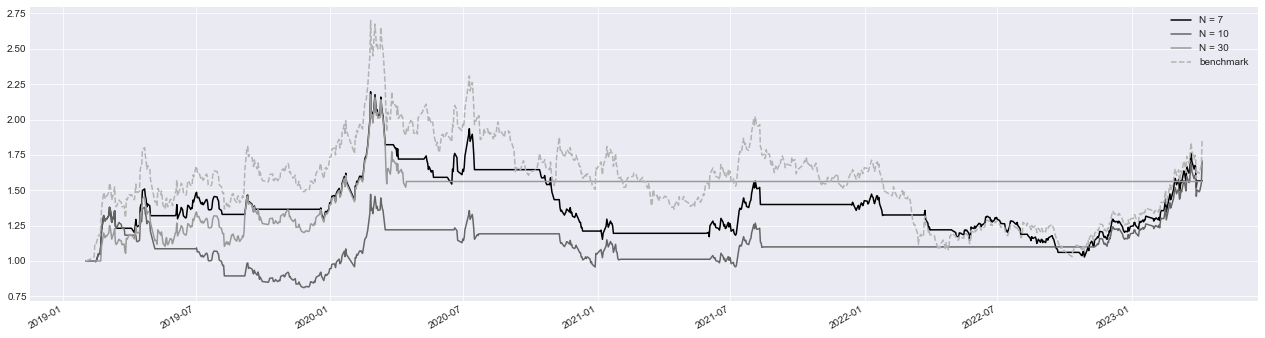

In [59]:
optimizer([7, 10, 30], plot = True)

可见，都不太行（笑

原因很简单，今日昨日的均线值大小只能描述一两天的趋势，捕捉不到一段时间的肥尾效应，硬要改进的话可以从策略中采用的安全垫参数下手，也就是1.02和0.98